<a href="https://colab.research.google.com/github/Muhire-taa/Forex-makert-trading-advisory-and-forecasting/blob/main/GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib


--2023-08-11 07:46:02--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-11 07:46:02--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-11 07:46:02--  http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving versaweb.dl.s

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=a5c73b4be319ded12a0cea77d302c74f163a7d1f90e2b71a5d7599a0ccc7f382
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [ ]:
!pip install numpy==1.23.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [ ]:
import  ta
import talib
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GRU, LSTM, Bidirectional,Dropout
from keras import regularizers
from keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load the data for all timeframes
df_daily = pd.read_csv("/content/drive/MyDrive/financial_datasets/USDCHF_data_1D.csv")
df_4h = pd.read_csv("/content/drive/MyDrive/financial_datasets/USDCHF_data_4H.csv")
df_1h = pd.read_csv("/content/drive/MyDrive/financial_datasets/USDCHF_data_1H.csv")
df_30min = pd.read_csv("/content/drive/MyDrive/financial_datasets/USDCHF_data_30M.csv")


In [ ]:
# Create fibonaci retracements levels and indicators for all timeframes
def create_indicators(df, window_slow=26, window_fast=12, window_signal=9):
    ema = ta.trend.EMAIndicator(close=df['close'], window=8, fillna=False)
    df['EMA'] = ema.ema_indicator()
    df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=14).rsi()
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    bb = ta.volatility.BollingerBands(df['close'], window=20)
    df['upper_bb'] = bb.bollinger_hband()
    df['lower_bb'] = bb.bollinger_lband()
    # Calculate the Stochastic Oscillator using ta library
    stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14)
    # Add %K and %D to dataframe
    df['%K'] = stoch.stoch()
    df['%D'] = stoch.stoch_signal()
    #sma
    ema_21 = ta.trend.EMAIndicator(close=df['close'], window=21, fillna=False)
    df['EMA_21'] = ema.ema_indicator()
   #sma_18 = ta.trend.SMAIndicator(close=df['close'], window=30, fillna=False).sma_indicator()
   #df['sma_18'] = sma_18
    #ema_12 and sma_18 crossover
#     df['crossover_signal'] = np.where(df['EMA'] > df['EMA_21'], 1, -1)
    # macd
    ema_slow = df['close'].ewm(span=window_slow).mean()
    ema_fast = df['close'].ewm(span=window_fast).mean()

    # Calculate the MACD line
    macd_line = ema_fast - ema_slow

    # Calculate the signal line (EMA of MACD line)
    signal_line = macd_line.ewm(span=window_signal).mean()

    # Calculate the histogram
    histogram = macd_line - signal_line

    # Add the MACD indicators to the DataFrame
    df['macd_line'] = macd_line
    df['signal_line'] = signal_line
#     df['histogram'] = histogram
    # Define breakout signals
#     df['breakout_above_upper'] = np.where(df['close'] > df['upper_bb'], 1, -1)
#     df['breakout_below_lower'] = np.where(df['close'] < df['lower_bb'], -1, 1)
    # Calculate the rolling high, low, and diff values for the past 18 candles
    high = df['high'].rolling(window=48).max()
    low = df['low'].rolling(window=48).min()
    diff = high - low

    # Calculate the Fibonacci retracement levels for the rolling window
    fib_levels = [high - (x / 100) * diff for x in [23.6, 38.2, 50, 61.8,76.4]]

    # Add the Fibonacci retracement levels to the dataframe
    df['fib_23.6'] = fib_levels[0]
    df['fib_38.2'] = fib_levels[1]
    df['fib_50'] = fib_levels[2]
    df['fib_61.8'] = fib_levels[3]
    df['fib_76.4'] = fib_levels[4]
    # add special candlestick patterns for price reversals
    #candles for downtrend reversals
#     df['CDLHAMMER'] = talib.CDLHAMMER(df['open'], df['high'], df['low'], df['close'])
#     df['CDLMORNINGSTAR'] = talib.CDLMORNINGSTAR(df['open'], df['high'], df['low'], df['close'])
#     df['CDLENGULFING'] = talib.CDLENGULFING(df['open'], df['high'], df['low'], df['close'])
#     df['CDLPIERCING'] = talib.CDLPIERCING(df['open'], df['high'], df['low'], df['close'])
    df['CDLINVERTEDHAMMER'] = talib.CDLINVERTEDHAMMER(df['open'], df['high'], df['low'], df['close'])
    #candles for uptrend reversals
    df['CDLSHOOTINGSTAR'] = talib.CDLSHOOTINGSTAR(df['open'], df['high'], df['low'], df['close'])
#     df['CDLHANGINGMAN'] = talib.CDLHANGINGMAN(df['open'], df['high'], df['low'], df['close'])
#     df['CDLEVENINGSTAR'] = talib.CDLEVENINGSTAR(df['open'], df['high'], df['low'], df['close'])
#     df['CDLDARKCLOUDCOVER'] = talib.CDLDARKCLOUDCOVER(df['open'], df['high'], df['low'], df['close'])
    # Compute the rolling maximum and minimum prices
    window_size =48
    df['supply_zone'] = df['high'].rolling(window_size).max()
    df['demand_zone'] = df['low'].rolling(window_size).min()
    #df['breakout_above_supply_zone'] = np.where(df['close'] > df['supply_zone'], 1, -1)
    #df['breakout_below_demand_zone'] = np.where(df['close'] < df['demand_zone'], -1, 1)
    ci_lookback = 14
    tr1 = pd.DataFrame(df['high'] - df['low']).rename(columns={0: 'tr1'})
    tr2 = pd.DataFrame(abs(df['high'] - df['close'].shift(1))).rename(columns={0: 'tr2'})
    tr3 = pd.DataFrame(abs(df['low'] - df['close'].shift(1))).rename(columns={0: 'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis=1, join='inner').dropna().max(axis=1)
    atr = tr.rolling(1).mean()
    highh = df['high'].rolling(ci_lookback).max()
    lowl = df['low'].rolling(ci_lookback).min()
    ci = 100 * np.log10((atr.rolling(ci_lookback).sum()) / (highh - lowl)) / np.log10(ci_lookback)
    df['ci_14'] = ci
    #from ta.trend import ADXIndicator
    adxI = ta.trend.ADXIndicator(df['high'],df['low'],df['close'],14,False)
    df['pos_directional_indicator'] = adxI.adx_pos()
    df['neg_directional_indicator'] = adxI.adx_neg()
    df['adx'] = adxI.adx()

    df['bullish_breakout_ema_12'] = np.where(df['close'] > df['EMA'], 1, -1)
    df['bearish_breakout_ema_12'] = np.where(df['close'] < df['EMA'], -1, 1)
    lookback=14
    highh = high.rolling(lookback).max()
    lowl = low.rolling(lookback).min()
    wr = -100 * ((highh - df['close']) / (highh - lowl))
    df['wr_14']=wr

    return df

In [ ]:
daily_df = create_indicators(df_daily)
fourh_df = create_indicators(df_4h)
oneh_df = create_indicators(df_1h)
thirtymin_df = create_indicators(df_30min)

/usr/local/lib/python3.10/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.10/dist-pac

In [ ]:
# # Combine all dataframes into one
#df = pd.concat([daily_df, fourh_df, oneh_df,thirtymin_df], axis=0)
df=fourh_df


In [ ]:
# Drop any rows with NaN values
df.dropna(inplace=True)
df

,time,open,high,low,close,tick_volume,spread,real_volume,EMA,rsi,...,CDLSHOOTINGSTAR,supply_zone,demand_zone,ci_14,pos_directional_indicator,neg_directional_indicator,adx,bullish_breakout_ema_12,bearish_breakout_ema_12,wr_14
60,1978-04-06 00:00:00,1.86530,1.86530,1.86530,1.86530,1,50,0,1.872340,44.304468,...,0,1.98810,1.79600,27.871557,44.258813,55.741187,14.206095,-1,-1,-68.225585
61,1978-04-07 00:00:00,1.86920,1.86920,1.86920,1.86920,1,50,0,1.871642,45.231990,...,0,1.98810,1.79600,24.872038,45.177182,54.822818,13.880348,-1,-1,-66.437414
62,1978-04-10 00:00:00,1.85600,1.85600,1.85600,1.85600,1,50,0,1.868166,42.643478,...,0,1.98810,1.79600,32.695756,42.617849,57.382151,13.943487,-1,-1,-72.489684
63,1978-04-11 00:00:00,1.85870,1.85870,1.85870,1.85870,1,50,0,1.866063,43.357516,...,0,1.98610,1.79600,31.600611,43.325099,56.674901,13.901081,-1,-1,-71.251719
64,1978-04-12 00:00:00,1.86570,1.86570,1.86570,1.86570,1,50,0,1.865982,45.260174,...,0,1.97860,1.79600,36.652022,45.210537,54.789463,13.592356,-1,-1,-68.042182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43474,2023-06-22 12:00:00,0.89401,0.89545,0.89214,0.89545,15062,0,0,0.894685,47.751411,...,0,0.91093,0.89018,49.632135,19.249040,22.490584,14.410152,1,1,-74.602410
43475,2023-06-22 16:00:00,0.89547,0.89706,0.89420,0.89690,16869,0,0,0.895177,52.493974,...,0,0.91065,0.89018,49.196336,22.220663,20.686450,13.636260,1,1,-67.614458
43476,2023-06-22 20:00:00,0.89689,0.89724,0.89443,0.89455,7636,2,0,0.895038,45.314962,...,0,0.90893,0.89018,50.095095,20.983347,19.068004,13.003828,-1,-1,-78.939759
43477,2023-06-23 00:00:00,0.89418,0.89550,0.89365,0.89512,8777,1,0,0.895056,47.201093,...,0,0.90893,0.89018,50.398168,19.880562,20.281724,12.146330,1,1,-76.192771


In [ ]:
# def get_ci(high, low, close, lookback):
#     tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
#     tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
#     tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
#     frames = [tr1, tr2, tr3]
#     tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
#     atr = tr.rolling(1).mean()
#     highh = high.rolling(lookback).max()
#     lowl = low.rolling(lookback).min()
#     ci = 100 * np.log10((atr.rolling(lookback).sum()) / (highh - lowl)) / np.log10(lookback)
#     return ci

# df['ci_14'] = get_ci(df['high'], df['low'], df['close'], 14)
# df = df.dropna()
# df

In [ ]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['close'].abs().sort_values(ascending=False)
print(correlation_with_target)

close                        1.000000
low                          0.999948
high                         0.999943
open                         0.999914
EMA                          0.999752
EMA_21                       0.999752
lower_bb                     0.998372
upper_bb                     0.998021
fib_61.8                     0.997621
fib_50                       0.997554
fib_76.4                     0.997470
fib_38.2                     0.997329
fib_23.6                     0.996848
demand_zone                  0.996622
supply_zone                  0.995646
spread                       0.783106
atr                          0.654933
tick_volume                  0.523606
pos_directional_indicator    0.383214
neg_directional_indicator    0.252020
ci_14                        0.165616
real_volume                  0.154120
wr_14                        0.058914
signal_line                  0.044733
rsi                          0.042879
macd_line                    0.041844
adx         

<ipython-input-148-28ad834cd852>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [ ]:
df.set_axis(df['time'], inplace=True)
df.drop(columns=['time','real_volume','tick_volume','spread'], inplace=True)
df

<ipython-input-149-5bc4c63196d8>:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(df['time'], inplace=True)


,open,high,low,close,EMA,rsi,atr,upper_bb,lower_bb,%K,...,CDLSHOOTINGSTAR,supply_zone,demand_zone,ci_14,pos_directional_indicator,neg_directional_indicator,adx,bullish_breakout_ema_12,bearish_breakout_ema_12,wr_14
time,,,,,,,,,,,,,,,,,,,,,
1978-04-06 00:00:00,1.86530,1.86530,1.86530,1.86530,1.872340,44.304468,0.017874,1.965225,1.833145,32.531280,...,0,1.98810,1.79600,27.871557,44.258813,55.741187,14.206095,-1,-1,-68.225585
1978-04-07 00:00:00,1.86920,1.86920,1.86920,1.86920,1.871642,45.231990,0.016876,1.956428,1.833172,36.284889,...,0,1.98810,1.79600,24.872038,45.177182,54.822818,13.880348,-1,-1,-66.437414
1978-04-10 00:00:00,1.85600,1.85600,1.85600,1.85600,1.868166,42.643478,0.016614,1.948774,1.831566,29.236277,...,0,1.98810,1.79600,32.695756,42.617849,57.382151,13.943487,-1,-1,-72.489684
1978-04-11 00:00:00,1.85870,1.85870,1.85870,1.85870,1.866063,43.357516,0.015620,1.940601,1.831249,34.561626,...,0,1.98610,1.79600,31.600611,43.325099,56.674901,13.901081,-1,-1,-71.251719
1978-04-12 00:00:00,1.86570,1.86570,1.86570,1.86570,1.865982,45.260174,0.015004,1.932692,1.832158,49.137931,...,0,1.97860,1.79600,36.652022,45.210537,54.789463,13.592356,-1,-1,-68.042182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-22 12:00:00,0.89401,0.89545,0.89214,0.89545,0.894685,47.751411,0.002523,0.899666,0.892220,50.529661,...,0,0.91093,0.89018,49.632135,19.249040,22.490584,14.410152,1,1,-74.602410
2023-06-22 16:00:00,0.89547,0.89706,0.89420,0.89690,0.895177,52.493974,0.002547,0.899752,0.892358,65.889831,...,0,0.91065,0.89018,49.196336,22.220663,20.686450,13.636260,1,1,-67.614458
2023-06-22 20:00:00,0.89689,0.89724,0.89443,0.89455,0.895038,45.314962,0.002565,0.899757,0.892267,40.995763,...,0,0.90893,0.89018,50.095095,20.983347,19.068004,13.003828,-1,-1,-78.939759


In [ ]:
columns_of_interest = ['open', 'high', 'low', 'close', 'EMA', 'rsi', 'atr', 'upper_bb',
       'lower_bb', '%K', '%D', 'EMA_21', 'macd_line', 'signal_line',
       'fib_23.6', 'fib_38.2', 'fib_50', 'fib_61.8', 'fib_76.4',
       'CDLINVERTEDHAMMER', 'CDLSHOOTINGSTAR', 'supply_zone', 'demand_zone',
       'bullish_breakout_ema_12', 'bearish_breakout_ema_12']

# Function to drop outliers using Z-score method for the specified columns
def drop_outliers_zscore(data, threshold=5):
    z_scores = data[columns_of_interest].apply(lambda x: (x - x.mean()) / x.std())
    outlier_indices = z_scores[abs(z_scores) > threshold].any(axis=1)
    return data[~outlier_indices]

# Drop outliers using Z-score method for the specified columns
df_without_outliers = drop_outliers_zscore(df)
df=df_without_outliers

In [ ]:
df

,open,high,low,close,EMA,rsi,atr,upper_bb,lower_bb,%K,...,fib_50,fib_61.8,fib_76.4,CDLINVERTEDHAMMER,CDLSHOOTINGSTAR,supply_zone,demand_zone,ci_14,bullish_breakout_ema_12,bearish_breakout_ema_12
time,,,,,,,,,,,,,,,,,,,,,
1978-03-20 00:00:00,1.92050,1.92050,1.92050,1.92050,1.913503,51.592265,0.021606,1.980958,1.784592,62.874251,...,1.905050,1.879314,1.847472,0,0,2.01410,1.79600,28.146126,1,1
1978-03-21 00:00:00,1.93540,1.93540,1.93540,1.93540,1.918369,54.076717,0.021127,1.986134,1.789136,74.026946,...,1.905050,1.879314,1.847472,0,0,2.01410,1.79600,27.997396,1,1
1978-03-22 00:00:00,1.91530,1.91530,1.91530,1.91530,1.917687,50.324486,0.021053,1.987094,1.797056,50.807899,...,1.905050,1.879314,1.847472,0,0,2.01410,1.79600,37.512950,-1,-1
1978-03-23 00:00:00,1.91020,1.91020,1.91020,1.91020,1.916023,49.388088,0.019914,1.982153,1.813417,35.032538,...,1.905050,1.879314,1.847472,0,0,2.01410,1.79600,42.455544,-1,-1
1978-03-24 00:00:00,1.90110,1.90110,1.90110,1.90110,1.912707,47.683176,0.019141,1.981944,1.818546,24.259056,...,1.905050,1.879314,1.847472,0,0,2.01410,1.79600,41.531789,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-22 12:00:00,0.89401,0.89545,0.89214,0.89545,0.894685,47.751411,0.002523,0.899666,0.892220,50.529661,...,0.900555,0.898107,0.895077,0,0,0.91093,0.89018,49.632135,1,1
2023-06-22 16:00:00,0.89547,0.89706,0.89420,0.89690,0.895177,52.493974,0.002547,0.899752,0.892358,65.889831,...,0.900415,0.898000,0.895011,0,0,0.91065,0.89018,49.196336,1,1
2023-06-22 20:00:00,0.89689,0.89724,0.89443,0.89455,0.895038,45.314962,0.002565,0.899757,0.892267,40.995763,...,0.899555,0.897343,0.894605,0,0,0.90893,0.89018,50.095095,-1,-1


In [ ]:
# ((197640-191843 )/197640)*100

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc_Y = MinMaxScaler()
scaled_data = sc.fit_transform(df)
sc_Y.fit(df['close'].values.reshape(-1,1))

MinMaxScaler()

In [ ]:
N_past =12
M_future =1

In [ ]:
test_percentage = 0.15
test_split = int(len(scaled_data)*(1 - test_percentage))

In [ ]:
train = scaled_data[:test_split]
test = scaled_data[test_split-N_past:]
print(train.shape)
print(test.shape)

(36087, 26)
(6381, 26)


In [ ]:
def split_dataset_X_Y(data,past,future,jump=1):
    X,Y=[],[]
    for i in range(0,len(data)-past-future+1,jump):
        X.append(df[i:(i+past)].values)
        Y.append(df['close'][(i+past):(i+past+future)])
    return np.array(X),np.array(Y)

In [ ]:
X_train, y_train = split_dataset_X_Y(train, N_past, M_future)
X_test, y_test = split_dataset_X_Y(test, N_past, M_future)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
EPOCHS = 100
model = Sequential()
model.add(LSTM(32, input_shape=(N_past, df.shape[1]),activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001),return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32,activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001),return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(LSTM(128,activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001),return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001),return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(M_future))
#build the model
model.build(input_shape=(None, N_past, df.shape[1]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 32)            7552      
                                                                 
 batch_normalization_4 (Batc  (None, 12, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 12, 32)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 12, 64)           16640     
 nal)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 12, 64)           256       
 hNormalization)                                                 
                                                      

In [ ]:
# Compile the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.00001), metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
# Set up early stopping to prevent overfitting
early_stop =EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(f'usdchf.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_validation, y_validation), shuffle=False, batch_size=16, verbose=2,callbacks=[early_stop,checkpoint])

Epoch 1/100

Epoch 1: val_loss improved from inf to 2.17123, saving model to usdchf.h5
1917/1917 - 44s - loss: 3.1283 - mse: 2.0553 - mae: 1.1884 - rmse: 1.4336 - val_loss: 2.1712 - val_mse: 1.1013 - val_mae: 0.9752 - val_rmse: 1.0494 - 44s/epoch - 23ms/step
Epoch 2/100

Epoch 2: val_loss improved from 2.17123 to 1.64114, saving model to usdchf.h5
1917/1917 - 29s - loss: 2.3471 - mse: 1.2805 - mae: 0.9229 - rmse: 1.1316 - val_loss: 1.6411 - val_mse: 0.5780 - val_mae: 0.6904 - val_rmse: 0.7603 - 29s/epoch - 15ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.64114 to 1.29840, saving model to usdchf.h5
1917/1917 - 29s - loss: 1.9160 - mse: 0.8566 - mae: 0.7417 - rmse: 0.9255 - val_loss: 1.2984 - val_mse: 0.2427 - val_mae: 0.4127 - val_rmse: 0.4927 - 29s/epoch - 15ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.29840 to 1.15906, saving model to usdchf.h5
1917/1917 - 29s - loss: 1.6934 - mse: 0.6417 - mae: 0.6352 - rmse: 0.8011 - val_loss: 1.1591 - val_mse: 0.1114 - val_mae: 0.

KeyboardInterrupt: ignored

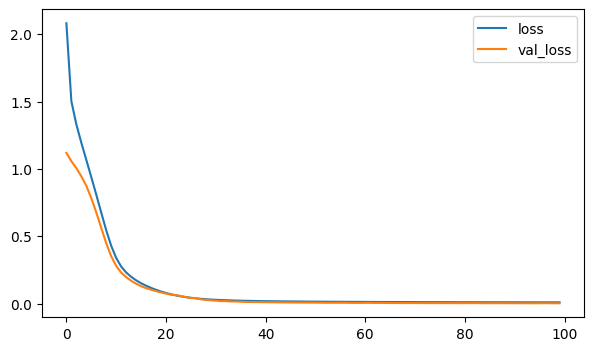

In [ ]:
plt.figure(figsize = (7,4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

927/927 [==============================] - 7s 5ms/step


In [ ]:
index_values = pd.RangeIndex(start=N_past, stop=N_past + len(y_test))
new_df = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,0].reshape(-1,1)).flatten(),
                       'y_pred': sc_Y.inverse_transform(y_pred[:,0].reshape(-1,1)).flatten()},
                      index=index_values)

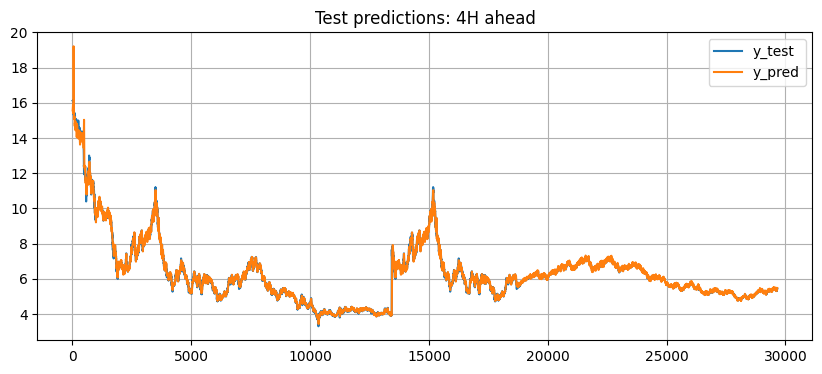

In [ ]:
fig = plt.figure(figsize=(10,4))
new_df['y_test'].plot()
new_df['y_pred'].plot()
plt.legend(loc='best')
plt.title('Test predictions: 4H ahead')
plt.grid(True)
plt.show()

In [ ]:
import sklearn.metrics as metrics
y_pred_test_lstm = model.predict(X_test)
y_train_pred_lstm = model.predict(X_train)
train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)
test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))
print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

4462/4462 [==============================] - 26s 6ms/step
The  MAE on the Train set is:	0.006
The  RMSE on the Train set is:	0.014
The  MAE on the Test set is:	0.015
The  RMSE on the Test set is:	0.033


In [ ]:
test_loss=model.evaluate(X_test,y_test)
print('test_loss:',test_loss[0])

927/927 [==============================] - 8s 9ms/step - loss: 0.0025 - mse: 0.0011 - mae: 0.0151 - rmse: 0.0329
test_loss: 0.0025179137010127306
